In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
from pprint import pprint
from itertools import chain

from IPython.display import Image, display
from lark import tree as larkTree
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph

from lark import Lark, Token, Transformer, Tree
from lark.indenter import Indenter

def display_tree(t, filename='viz.png'):
    larkTree.pydot__tree_to_png(t, filename)
    display(Image(filename))
    os.remove(filename)
    

def display_graph(g, filename='viz.png'):
    A = to_agraph(g)
    A.layout('dot')
    A.draw(filename)
    display(Image(filename))
    os.remove(filename)


In [2]:
NOTES_FOLDER = './roam-export/'
file_paths = os.listdir(NOTES_FOLDER)

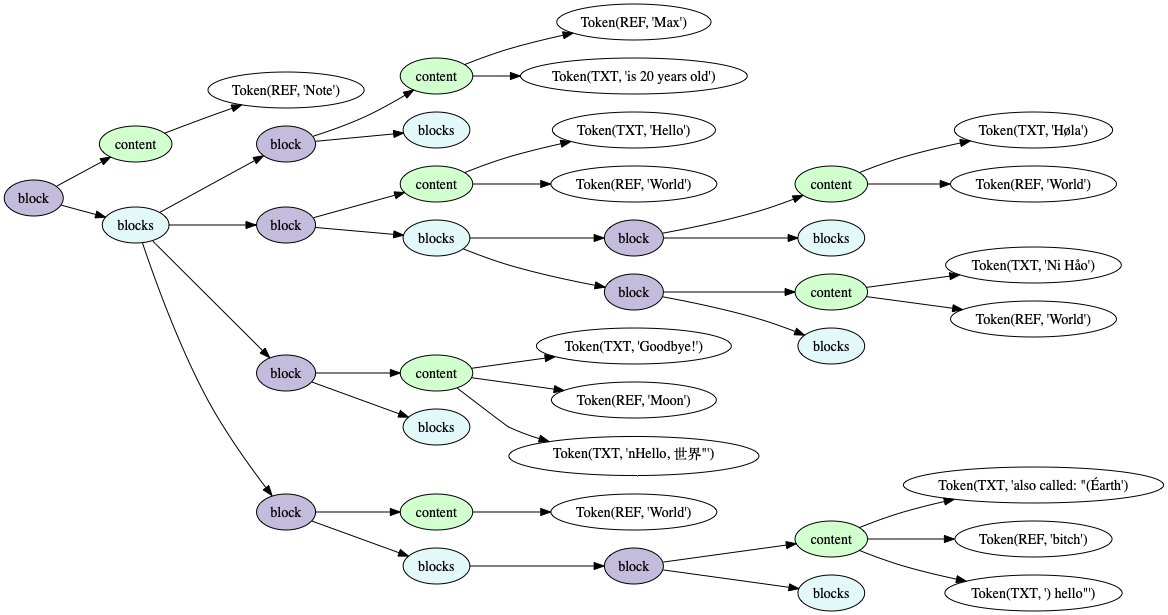

In [3]:

GRAMMAR = open('./grammar.lark').read()

class TreeIndenter(Indenter):
    """A lexical processor for indentation"""
    NL_type = '_NL'
    OPEN_PAREN_types = ["OPEN_REF"]
    CLOSE_PAREN_types = ["CLOSE_REF"]
    INDENT_type = '_INDENT'
    DEDENT_type = '_DEDENT'
    tab_len = 8


class TreeTransformer(Transformer):
    """Pos-processing to modify the lark generated tree"""
    @staticmethod
    def text(items):
        """Join words under text nodes in the AST"""
        return Token('TXT', ' '.join(items))

    @staticmethod
    def reference(items):
        """Join words under reference nodes in the AST"""
        return Token('REF', ' '.join(items))

PARSER = Lark(
    GRAMMAR,
    parser='lalr',
    postlex=TreeIndenter(),
    transformer=TreeTransformer)


def ast_from_text(text, root_content=[]):
    """Parse text into an array of block ASTs"""
    if len(root_content) > 0:
        return Tree('block', [Tree('content', root_content), PARSER.parse(text)] )
    return PARSER.parse(text)

ast = ast_from_text('''
- [[Max]] is 20 years old
- Hello [[World]]
  - Høla [[World]]
  - Ni Håo [[World]]
- Goodbye! [[Moon]] nHello, 世界"
- [[World]]
  - also called: "(Éarth [[bitch]]) hello"
''', [Token('REF', 'Note')])

display_tree(ast)

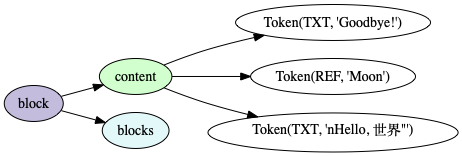

In [4]:

# Get trees with data
all_blocks = list(ast.find_data('block'))          
display_tree(all_blocks[4])


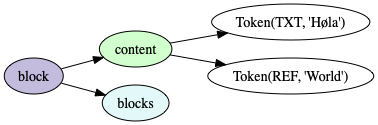

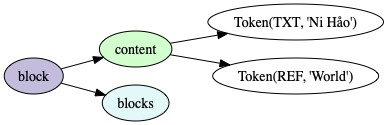

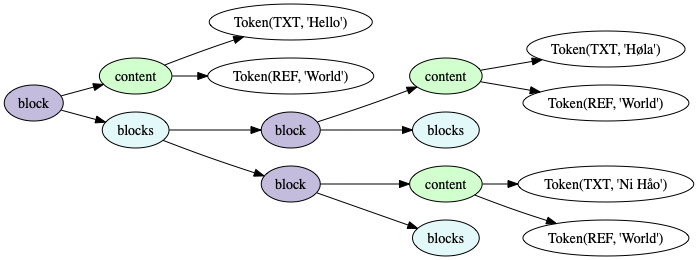

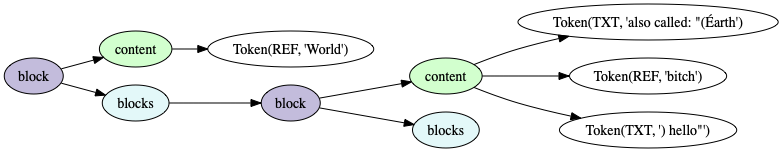

In [5]:
# get blocks containing a reference with <value>
def get_blocks_with_ref(value, blocks):
    results = []
    for block in blocks:
        for token in block.children[0].children:
            if token.type == 'REF' and token.value == value:
                results.append(block)
    return results

for b in get_blocks_with_ref('World', all_blocks):
    display_tree(b)

filler block bitch


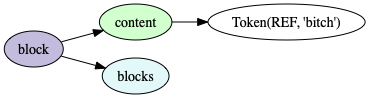

filler block Max


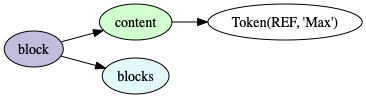

filler block Moon


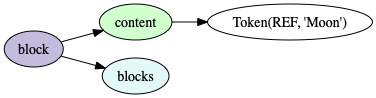

In [6]:
# add artificial blocks
all_refs = set([])
for block in all_blocks:
    for token in block.children[0].children:
        if token.type == 'REF':
            all_refs.add(token)

for ref in all_refs:
    bs = get_blocks_with_ref(ref, all_blocks)
    if len([x for x in bs if len(x.children[0].children) == 1]) == 0:
        print('filler block', ref)
        t = Tree('block', [
            Tree('content', [ref]),
            Tree('blocks', [])
        ])
        display_tree(t)
        all_blocks.append(t)


In [7]:
# assign IDs to each block
id_to_block = {}
block_to_id = {}
for i, block in enumerate(all_blocks):
    _id = str(i)
    id_to_block[_id] = block
    block_to_id[block] = _id

print(id_to_block.keys())
print('id to block:')
print(list(id_to_block.items())[0])

print('block to id:')
print(list(block_to_id.items())[0])

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
id to block:
('0', Tree(block, [Tree(content, [Token(REF, 'Max'), Token(TXT, 'is 20 years old')]), Tree(blocks, [])]))
block to id:
(Tree(block, [Tree(content, [Token(REF, 'Max'), Token(TXT, 'is 20 years old')]), Tree(blocks, [])]), '0')


parent:


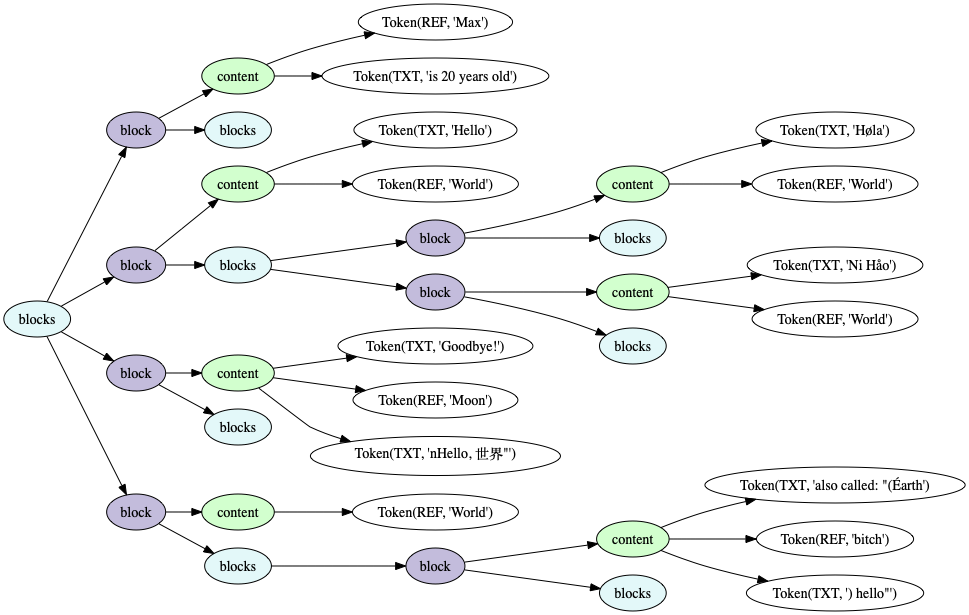

children:


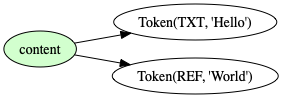

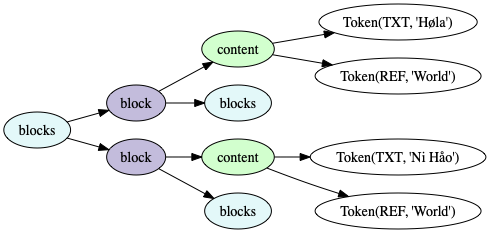

In [8]:
# Get immediate children blocks of <parent> block
def get_immediate_children(parent):
    return list(parent.children[1].children)

parent = ast.children[1]
print('parent:')
display_tree(parent)
print('children:')
for b in get_immediate_children(parent):
    display_tree(b)

child:


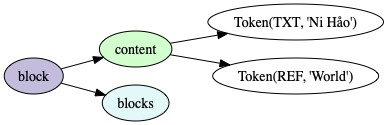

parent:


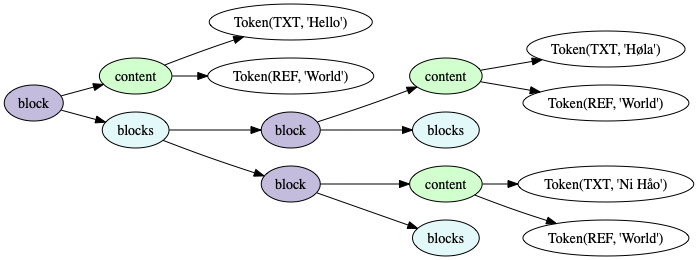

In [9]:
# get immediate parent block of <child> block
def get_immediate_parent(child, blocks):
    for block in blocks:
        if child in block.children[1].children:
            return block

child = all_blocks[2]
print('child:')
display_tree(child)

print('parent:')
display_tree(get_immediate_parent(child, all_blocks))

- a textblock's children are it's immediate children as well as any children to textblock's which are references to it

- occurences of a textblock are any other textblocks with content that includes a reference to it (via id, etc) AND other textblocks which are parents of it and its immediate parent.


- textblocks are indexed by id primarily, references, etc are secondary. When you use a special link, it must be resolved to an id

    - and special links must be resolved while searching for occurences/children

In [10]:
def token_to_json(token):
    return {
        'type': token.type,
        'value': token.value
    }

def block_to_json(block):
    return {
        'content': [token_to_json(x) for x in block.children[0].children],
        'children': [block_to_json(x) for x in block.children[1].children],
        'id': block_to_id[block]
    }

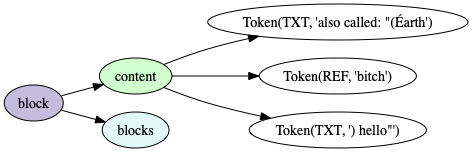

{'content': [{'type': 'TXT', 'value': 'also called: "(Éarth'},
  {'type': 'REF', 'value': 'bitch'},
  {'type': 'TXT', 'value': ') hello"'}],
 'children': [],
 'id': '5'}

In [11]:
def block_by_id(id):
    block = id_to_block[id]
    return block_to_json(block)

display_tree(all_blocks[5])
block_by_id('5')

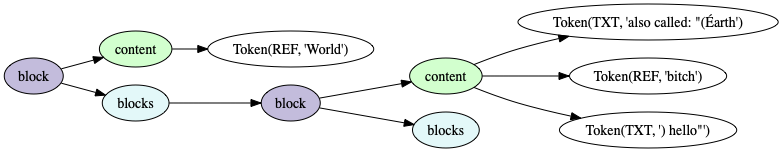

In [12]:
def occurences_by_id(id, blocks):
    block = id_to_block[id]        
    parent = get_immediate_parent(block, blocks)
    refs = get_blocks_with_ref(id, blocks)
    if len(block.children[0].children) == 1 and block.children[0].children[0].type == 'REF':
        refs += get_blocks_with_ref(block.children[0].children[0].value, blocks)
    results = refs + [parent]
    return [x for x in results if x is not None]

display_tree(occurences_by_id('5', all_blocks)[0])


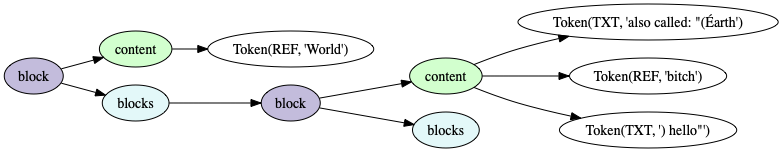

In [13]:
def ref_to_id(ref, blocks):
    occurences = get_blocks_with_ref(ref, blocks)
    for blk in blocks:
        if len(blk.children[0].children) == 1 and blk.children[0].children[0].type == 'REF' and blk.children[0].children[0].value == ref:
            return block_to_id[blk]
        
ref_to_id('World', all_blocks)
display_tree(id_to_block['6'])


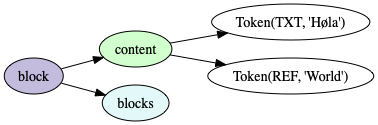

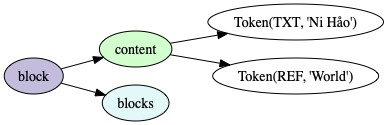

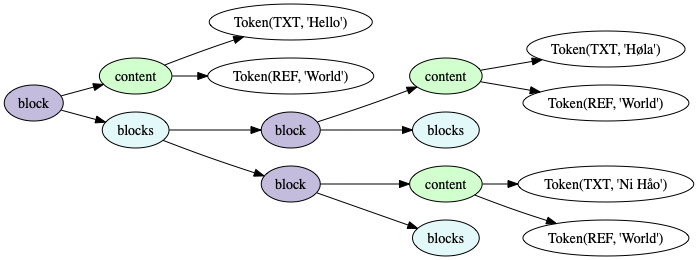

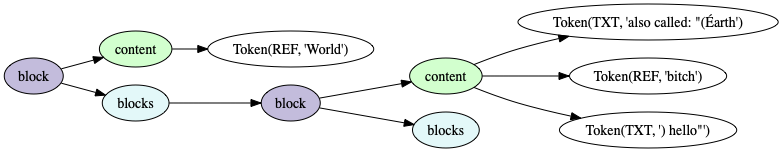

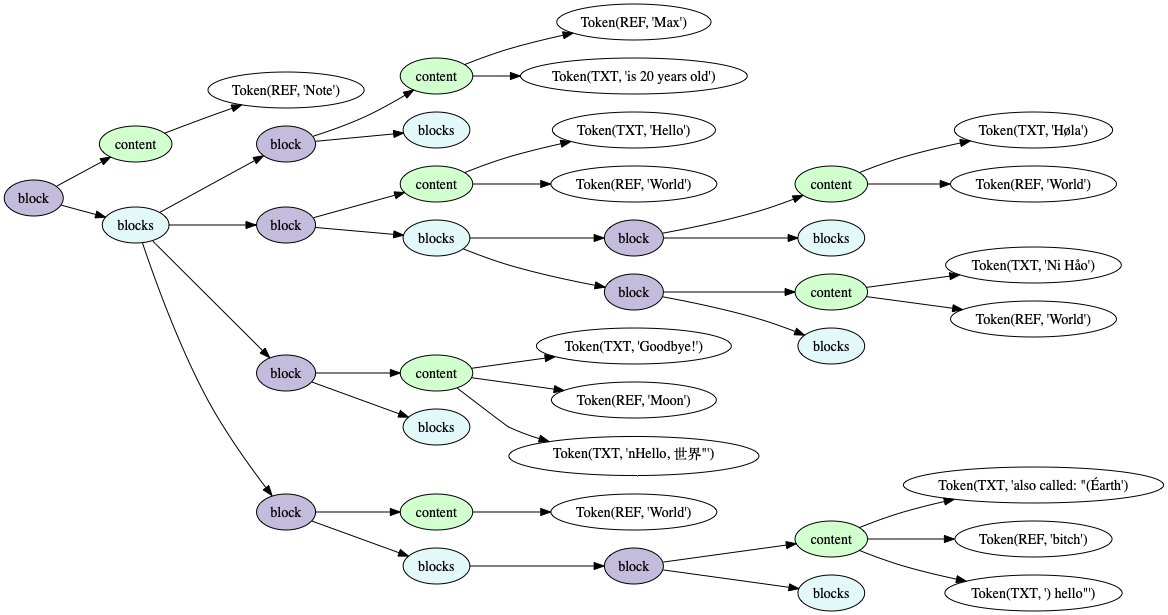

In [14]:
for b in occurences_by_id('6', all_blocks):
    display_tree(b)

In [28]:

def parse(text, root_content=None):
    print(text.split('\n'))
    

pages = []
for path in file_paths:
    name = path.replace('.md', '')
    print(name)
    text = open(NOTES_FOLDER + path).read()
    parse(text, root_content=[Token('REF', name)])
    break
#     ast = ast_from_text(text, [Token('REF', name)])

#     pages.append(ast)

Or in Roam
['- Implementation', '    - ```{{or: option a| option b| Option C}}```', '- Result', '    - {{or: option a | Option C | option b}}', "- This can be useful when you're figuring out word choice but want to remain consistent", '    - Fun Experiment to try', '        - Use this with [[Russel Conjugations]]', '            - Example', '                - {{or: strong willed | pig headed | stubborn}}', '                    - Jane is so "{{or: strong willed | pig headed | stubborn}}"! How did we end up with so many "{{or: strong willed | pig headed | stubborn}}" people like Jane.', '                    - ', '- status:: [[hidden]]', '']
